# Lecture 19 - Recurrent Neural Networks

***
##### CS 434 - Data Mining and Machine Learning
##### Oregon State University-Cascades
***

In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Embedding
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Bidirectional
from collections import Counter
import numpy as np
import pandas as pd
import os
import gzip
import shutil

# <img src="https://img.icons8.com/color/32/000000/workflow.png"/> Sequential data

For many machine learning algorithms, we assume that the input is independent and identically distributed (IID) data. This means that the training examples are *mutually independent* and have the same underlying distribution.

This assumption is not valid when we deal with sequences. In this case order matters.  

## <img src="https://img.icons8.com/color/32/000000/serial-tasks.png"/> Representing sequences

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch16/images/16_01.png width="800">

## <img src="https://img.icons8.com/color/32/000000/categorize.png"/>  Categories of sequence modeling

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch16/images/16_02.png width="800">

# <img src="https://img.icons8.com/color/32/000000/vector.png"/> RNNs for modeling sequences



##<img src="https://img.icons8.com/color/32/000000/repeat.png"/> Understanding the RNN looping mechanism

In the following, he input layer ($\mathbf{x}$), hidden layer ($\mathbf{h}$), and output layer ($\mathbf{o}$) are vectors that contain many units.

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch16/images/16_03.png width="800">

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch16/images/16_04.png width="800">

##  <img src="https://img.icons8.com/color/32/000000/abacus.png"/> Computing activations in an RNN


* $\textbf{W}_{xh}$ :  weight matrix between the input $\textbf{x}^t$ and the hidden layer $\textbf{h}$
* $\textbf{W}_{hh}$ : weight matrix associated with the recurrent edge
* $\textbf{W}_{ho}$ : weight matrix between the hidden layer and output layer

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch16/images/16_05.png width="800">

For the hidden layer the net input $\textbf{z}_h$ (preactivation), is computed through a linear combination.  We compute the sum of multiplications of the weight matrices with the corresponding vectors and add the bias unit:

$$\textbf{z}_h^t = \textbf{W}_{xh}\textbf{x}^t + \textbf{W}_{hh}\textbf{h}^{t-1} + \textbf{b}_h$$

Then the activations of the hidden units at the time step $t$ are calculated as follows:

$$\textbf{h}^t = \phi_h(\textbf{z}^t_h) = \phi_h(\textbf{W}_{xh}\textbf{x}^t + \textbf{W}_{hh}\textbf{h}^{t-1} + \textbf{b}_h)$$

or we can use the concatenated weight matrix, $\textbf{W}_h = [ \ \textbf{W}_{xh}; \textbf{W}_{hh} \ ]$, which results in:

$$\textbf{h}^t = \phi_h(\textbf{z}^t_h) = \phi_h( [ \ \textbf{W}_{xh}; \textbf{W}_{hh} \ ] \begin{bmatrix}
\textbf{x}^t \\
\textbf{h}^{t-1}
\end{bmatrix}  + \textbf{b}_h)$$

where 
* $\textbf{b}_h$ is the bias vector for the hidden units
* $\phi_h(\cdot)$ is the activation function of the hidden layer

Once the activations of the hidden units at the current time step are computed, then the activations of the output units will be computed, as follows:

$$\textbf{o}^t = \phi_o(\textbf{W}_{ho}\textbf{h}^t + \textbf{b}_o)$$

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch16/images/16_06.png width="800">

## <img src="https://img.icons8.com/color/32/000000/invisible.png"/> Hidden-recurrence vs. output-recurrence

The net activations from the output layer the previous time step $\textbf{o}^{t-1}$ can be added in one of two ways.

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch16/images/16_07.png width="800">

In [0]:
# create the layer and assign the weights
tf.random.set_seed(1)

rnn_layer = tf.keras.layers.SimpleRNN(
    units=2, use_bias=True, 
    return_sequences=True)
rnn_layer.build(input_shape=(None, None, 5))

w_xh, w_oo, b_h = rnn_layer.weights

print('W_xh shape:', w_xh.shape)
print('W_oo shape:', w_oo.shape)
print('b_h shape:', b_h.shape)

W_xh shape: (5, 2)
W_oo shape: (2, 2)
b_h shape: (2,)


In [0]:
# create tensor
x_seq = tf.convert_to_tensor(
    [[1.0]*5, [2.0]*5, [3.0]*5],
    dtype=tf.float32)

## output of SimepleRNN:
output = rnn_layer(tf.reshape(x_seq, shape=(1, 3, 5)))

## manually computing the output:
out_man = []
for t in range(len(x_seq)):
    xt = tf.reshape(x_seq[t], (1, 5))
    print('Time step {} =>'.format(t))
    print('   Input           :', xt.numpy())
    
    ht = tf.matmul(xt, w_xh) + b_h    
    print('   Hidden          :', ht.numpy())
    
    if t>0:
        prev_o = out_man[t-1]
    else:
        prev_o = tf.zeros(shape=(ht.shape))
        
    ot = ht + tf.matmul(prev_o, w_oo)
    ot = tf.math.tanh(ot)
    out_man.append(ot)
    print('   Output (manual) :', ot.numpy())
    print('   SimpleRNN output:'.format(t), output[0][t].numpy())
    print()

Time step 0 =>
   Input           : [[1. 1. 1. 1. 1.]]
   Hidden          : [[0.41464037 0.96012145]]
   Output (manual) : [[0.39240566 0.74433106]]
   SimpleRNN output: [0.39240566 0.74433106]

Time step 1 =>
   Input           : [[2. 2. 2. 2. 2.]]
   Hidden          : [[0.82928073 1.9202429 ]]
   Output (manual) : [[0.80116504 0.9912947 ]]
   SimpleRNN output: [0.80116504 0.9912947 ]

Time step 2 =>
   Input           : [[3. 3. 3. 3. 3.]]
   Hidden          : [[1.243921  2.8803642]]
   Output (manual) : [[0.95468265 0.9993069 ]]
   SimpleRNN output: [0.95468265 0.9993069 ]



## <img src="https://img.icons8.com/color/32/000000/hard-to-find.png"/> Challenges of learning long-range interactions


Because of the multiplicative factor ${\partial \textbf{h}^t \over {\partial \textbf{h}^k}}$, in computing the gradients of a loss functions, the so-called **vanishing** and **exploding** gradient problems arise. 

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch16/images/16_08.png width="800">


## <img src="https://img.icons8.com/color/32/000000/micro-sd.png"/> Long Short-Term Memory cells 

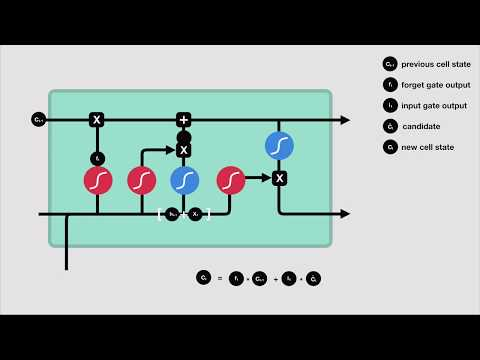

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo('8HyCNIVRbSU')

LSTMs were introduced to overcome the vanishing gradient problem. The building block of an LSTM is a **memory cell** which replaces the hidden layer of a standard RNN.

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch16/images/16_09.png width="800">

The **forget gate** $\textbf{f}_t$ allows the memory cell to reset the cell state without growing indefinitely. In fact, the forget gate decides which information is allowed to go through and which information to suppress. 

$$\textbf{f}_t = \sigma(\textbf{W}_{xf}\textbf{x}^t + \textbf{W}_{hf}\textbf{h}^{t-1} + \textbf{b}_f)$$

The **input gate** $\textbf{i}_t$ and **candiate value** $\widetilde {C}_t$ are responsible for updating the cell state. They are computed as follows:

$$\textbf{i}_t = \sigma(\textbf{W}_{xi}\textbf{x}^t + \textbf{W}_{hi}\textbf{h}^{t-1} + \textbf{b}_i)$$

$$\widetilde{C}_t = \tanh(\textbf{W}_{xc}\textbf{x}^t + \textbf{W}_{hc}\textbf{h}^{t-1} + \textbf{b}_c)$$

The cell state at time $t$ is computed as follows:

$$\textbf{C}^t = (\textbf{C}^{t-1} \ \odot \ \textbf{f}_t) \ \otimes \ (\textbf{i}_t \ \odot \ \widetilde{C}_j )$$

The **output gate** $\textbf{o}_t$ decides how to update the values of the hidden units:

$$\textbf{o}_t = \sigma(\textbf{W}_{xo}\textbf{x}^t + \textbf{W}_{ho}\textbf{h}^{t-1} + \textbf{b}_o)$$

Given this, the hidden units at the current time step are computed as follows:

$$\textbf{h}^t = \textbf{o}_t \odot \tanh(\textbf{C}^t)$$

# <img src="https://img.icons8.com/color/32/000000/new-document.png"/> Implementing RNNs for sequence modeling in TensorFlow


## <img src="https://img.icons8.com/color/32/000000/imdb.png"/> Project one: predicting the sentiment of IMDb movie reviews




**Sentiment** analysis is concerned with analyzing the expressed opinion of a sentence or text document. 

### <img src="https://img.icons8.com/color/32/000000/database-restore.png"/> Preparing the movie review data

In [0]:
with gzip.open('../ch08/movie_data.csv.gz', 'rb') as f_in, open('movie_data.csv', 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

In [0]:
df = pd.read_csv('movie_data.csv', encoding='utf-8')

df.tail()

,review,sentiment
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0
49999,I waited long to watch this movie. Also becaus...,1


#### <img src="https://img.icons8.com/color/32/000000/stairs.png"/> Pre-processing steps

**Step 1**. Create a TensorFlow dataset object and split it into separate training, testing, and validation partitions.

In [0]:
# Step 1: Create a dataset

target = df.pop('sentiment')

ds_raw = tf.data.Dataset.from_tensor_slices(
    (df.values, target.values))

## inspection:
for ex in ds_raw.take(3):
    tf.print(ex[0].numpy()[0][:50], ex[1])

b'In 1974, the teenager Martha Moxley (Maggie Grace)' 1
b'OK... so... I really like Kris Kristofferson and h' 0
b'***SPOILER*** Do not read this, if you think about' 0


 * **Train/validation/test splits**

In [0]:
# split to train/test/validation
tf.random.set_seed(1)

ds_raw = ds_raw.shuffle(
    50000, reshuffle_each_iteration=False)

ds_raw_test = ds_raw.take(25000)
ds_raw_train_valid = ds_raw.skip(25000)
ds_raw_train = ds_raw_train_valid.take(20000)
ds_raw_valid = ds_raw_train_valid.skip(20000)

**Step 2.** Identify the unique words in the training dataset.

 * **Tokenizer and Encoder**
   * `tfds.features.text.Tokenizer`: https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/Tokenizer
   * `tfds.features.text.TokenTextEncoder`: https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/TokenTextEncoder

In [0]:
## Step 2: find unique tokens (words)
tokenizer = tfds.features.text.Tokenizer()
token_counts = Counter()

for example in ds_raw_train:
    tokens = tokenizer.tokenize(example[0].numpy()[0])
    token_counts.update(tokens)
    
print('Vocab-size:', len(token_counts))

Vocab-size: 87007


**Step 3.** Map each unique word to a unique integer and encode the review text into encoded integers (an index of each unique word).

In [0]:
## Step 3: encoding each unique token into integers

encoder = tfds.features.text.TokenTextEncoder(token_counts)

example_str = 'This is an example!'
encoder.encode(example_str)

[232, 9, 270, 1123]

In [0]:
## Step 3-A: define the function for transformation

def encode(text_tensor, label):
    text = text_tensor.numpy()[0]
    encoded_text = encoder.encode(text)
    return encoded_text, label

## Step 3-B: wrap the encode function to a TF Op.
def encode_map_fn(text, label):
    return tf.py_function(encode, inp=[text, label], 
                          Tout=(tf.int64, tf.int64))

In [0]:
# encode text
ds_train = ds_raw_train.map(encode_map_fn)
ds_valid = ds_raw_valid.map(encode_map_fn)
ds_test = ds_raw_test.map(encode_map_fn)

tf.random.set_seed(1)
for example in ds_train.shuffle(1000).take(5):
    print('Sequence length:', example[0].shape)
    
example

Sequence length: (24,)
Sequence length: (179,)
Sequence length: (262,)
Sequence length: (535,)
Sequence length: (130,)


(<tf.Tensor: id=43302, shape=(130,), dtype=int64, numpy=
 array([  579,  1296,    32,   425,    40,   763,  9267,    65,   280,
          308,     6,   481,   155,   473,     2,     3,   684,     9,
          781,   176,   959,   730,  3917,    67,  9905,    13,   277,
           24,    35,   371, 16368,     6,    14, 17231,    29,   187,
         1651,   489,   503,   480,   143,    32,   270,  5851,  2402,
           13,  3592,  3443,   425,  3313,   256,   257,  1577,   117,
            8,   698,   270,   564,    56,     8,    42,  7517,  2629,
          820,    25,    60,    79,   343,    32,   645,    14,   528,
          241,    32,  1980,     8,    56,     8,    42,  1364,   573,
         5183,    43,    12,  3870,    32,   312,   642,   251,  1401,
        17232,     8,   698,   257,   750,     2,     9,    76,   235,
            8,    42,   235,   840,   666,   258, 17233,   419,    32,
        17234,   585,   420,   840,    25,    40,    13,    14,   198,
          266,   623

> Note: **batch() vs. padded_batch()**

```python
# this will result in error

BATCH_SIZE = 32
train_data = all_encoded_data.batch(BATCH_SIZE)

next(iter(train_data))

# Running this will result in error
# We cannot apply .batch() to this dataset
```

In [0]:
## Take a small subset

ds_subset = ds_train.take(8)
for example in ds_subset:
    print('Individual size:', example[0].shape)

## batching the datasets
ds_batched = ds_subset.padded_batch(
    4, padded_shapes=([-1], []))

for batch in ds_batched:
    print('Batch dimension:', batch[0].shape)

Individual Shape: (119,)
Individual Shape: (688,)
Individual Shape: (308,)
Individual Shape: (204,)
Individual Shape: (326,)
Individual Shape: (240,)
Individual Shape: (127,)
Individual Shape: (453,)
Batch Shape: (4, 688)
Batch Shape: (4, 453)


In [0]:
## batching the datasets
train_data = ds_train.padded_batch(
    32, padded_shapes=([-1],[]))

valid_data = ds_valid.padded_batch(
    32, padded_shapes=([-1],[]))

test_data = ds_test.padded_batch(
    32, padded_shapes=([-1],[]))

### <img src="https://img.icons8.com/color/32/000000/layers.png"/> Embedding layers for sentence encoding


 * `input_dim`: number of words, i.e. maximum integer index + 1.
 * `output_dim`: 
 * `input_length`: the length of (padded) sequence
    * for example, `'This is an example' -> [0, 0, 0, 0, 0, 0, 3, 1, 8, 9]`   
    => input_length is 10
 
 

 * When calling the layer, takes integer values as input,   
 the embedding layer convert each integer into float vector of size `[output_dim]`
   * If input shape is `[BATCH_SIZE]`, output shape will be `[BATCH_SIZE, output_dim]`
   * If input shape is `[BATCH_SIZE, 10]`, output shape will be `[BATCH_SIZE, 10, output_dim]`

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch16/images/16_10.png width="800">

**Encoding sequences:** keeping the last 100 items in each sequence

In [0]:
model = tf.keras.Sequential()

model.add(Embedding(input_dim=100,
                    output_dim=6,
                    input_length=20,
                    name='embed-layer'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, 20, 6)             600       
Total params: 600
Trainable params: 600
Non-trainable params: 0
_________________________________________________________________


### <img src="https://img.icons8.com/color/32/000000/wrench.png"/> Building an RNN model

* **Keras RNN layers:**
  * `tf.keras.layers.SimpleRNN(units, return_sequences=False)`
  * `tf.keras.layers.LSTM(..)`
  * `tf.keras.layers.GRU(..)`
  * `tf.keras.layers.Bidirectional()`
 
* **Determine `return_sequenes=?`**
  * In a multi-layer RNN, all RNN layers except the last one should have `return_sequenes=True`
  * For the last RNN layer, decide based on the type of problem: 
     * many-to-many: -> `return_sequences=True`
     * many-to-one : -> `return_sequenes=False`
     * ..
    

In [0]:
## An example of building a RNN model
## with SimpleRNN layer

model = Sequential()
model.add(Embedding(1000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 36,193
Trainable params: 36,193
Non-trainable params: 0
_________________________________________________________________


In [0]:
## An example of building a RNN model
## with LSTM layer

model = Sequential()
model.add(Embedding(10000, 32))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 336,673
Trainable params: 336,673
Non-trainable params: 0
_________________________________________________________________


In [0]:
## An example of building a RNN model
## with GRU layer

model = Sequential()
model.add(Embedding(10000, 32))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
gru (GRU)                    (None, None, 32)          6336      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 332,705
Trainable params: 332,705
Non-trainable params: 0
_________________________________________________________________


### <img src="https://img.icons8.com/color/32/000000/bipolar-disease.png"/>  Building an RNN model for the sentiment analysis task

In [0]:
embedding_dim = 20
vocab_size = len(token_counts) + 2

tf.random.set_seed(1)

## build the model
bi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        name='embed-layer'),
    
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, name='lstm-layer'),
        name='bidir-lstm'), 

    tf.keras.layers.Dense(64, activation='relu'),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

bi_lstm_model.summary()

## compile and train:
bi_lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'])

history = bi_lstm_model.fit(
    train_data, 
    validation_data=valid_data, 
    epochs=10)

## evaluate on the test data
test_results= bi_lstm_model.evaluate(test_data)
print('Test Acc.: {:.2f}%'.format(test_results[1]*100))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, None, 20)          1740180   
_________________________________________________________________
bidir-lstm (Bidirectional)   (None, 128)               43520     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,792,021
Trainable params: 1,792,021
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 383s 613ms/step - loss: 0.5173 - accuracy: 0.7376 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
625/625 [==============================] - 369s 590ms/step - loss: 0.2747 - a

In [0]:
if not os.path.exists('models'):
    os.mkdir('models')

bi_lstm_model.save('models/Bidir-LSTM-full-length-seq.h5')

Try **SimpleRNN** with short sequences

In [0]:
# function to preprocess all data
def preprocess_datasets(
    ds_raw_train, 
    ds_raw_valid, 
    ds_raw_test,
    max_seq_length=None,
    batch_size=32):
    
    ## Step 1: (already done => creating a dataset)
    ## Step 2: find unique tokens
    tokenizer = tfds.features.text.Tokenizer()
    token_counts = Counter()

    for example in ds_raw_train:
        tokens = tokenizer.tokenize(example[0].numpy()[0])
        if max_seq_length is not None:
            tokens = tokens[-max_seq_length:]
        token_counts.update(tokens)

    print('Vocab-size:', len(token_counts))


    ## Step 3: encoding the texts
    encoder = tfds.features.text.TokenTextEncoder(token_counts)
    def encode(text_tensor, label):
        text = text_tensor.numpy()[0]
        encoded_text = encoder.encode(text)
        if max_seq_length is not None:
            encoded_text = encoded_text[-max_seq_length:]
        return encoded_text, label

    def encode_map_fn(text, label):
        return tf.py_function(encode, inp=[text, label], 
                              Tout=(tf.int64, tf.int64))

    ds_train = ds_raw_train.map(encode_map_fn)
    ds_valid = ds_raw_valid.map(encode_map_fn)
    ds_test = ds_raw_test.map(encode_map_fn)

    ## Step 4: batching the datasets
    train_data = ds_train.padded_batch(
        batch_size, padded_shapes=([-1],[]))

    valid_data = ds_valid.padded_batch(
        batch_size, padded_shapes=([-1],[]))

    test_data = ds_test.padded_batch(
        batch_size, padded_shapes=([-1],[]))

    return (train_data, valid_data, 
            test_data, len(token_counts))

In [0]:
# function to build RNN model
def build_rnn_model(embedding_dim, vocab_size,
                    recurrent_type='SimpleRNN',
                    n_recurrent_units=64,
                    n_recurrent_layers=1,
                    bidirectional=True):

    tf.random.set_seed(1)

    # build the model
    model = tf.keras.Sequential()
    
    model.add(
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            name='embed-layer')
    )
    
    for i in range(n_recurrent_layers):
        return_sequences = (i < n_recurrent_layers-1)
            
        if recurrent_type == 'SimpleRNN':
            recurrent_layer = SimpleRNN(
                units=n_recurrent_units, 
                return_sequences=return_sequences,
                name='simprnn-layer-{}'.format(i))
        elif recurrent_type == 'LSTM':
            recurrent_layer = LSTM(
                units=n_recurrent_units, 
                return_sequences=return_sequences,
                name='lstm-layer-{}'.format(i))
        elif recurrent_type == 'GRU':
            recurrent_layer = GRU(
                units=n_recurrent_units, 
                return_sequences=return_sequences,
                name='gru-layer-{}'.format(i))
        
        if bidirectional:
            recurrent_layer = Bidirectional(
                recurrent_layer, name='bidir-'+recurrent_layer.name)
            
        model.add(recurrent_layer)

    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    return model


In [0]:
# run simple RNN
batch_size = 32
embedding_dim = 20
max_seq_length = 100

train_data, valid_data, test_data, n = preprocess_datasets(
    ds_raw_train, ds_raw_valid, ds_raw_test, 
    max_seq_length=max_seq_length, 
    batch_size=batch_size
)


vocab_size = n + 2

rnn_model = build_rnn_model(
    embedding_dim, vocab_size,
    recurrent_type='SimpleRNN', 
    n_recurrent_units=64,
    n_recurrent_layers=1,
    bidirectional=True)

rnn_model.summary()

Vocab-size: 58063
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, None, 20)          1161300   
_________________________________________________________________
bidir-simprnn-layer-0 (Bidir (None, 128)               10880     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 1,180,501
Trainable params: 1,180,501
Non-trainable params: 0
_________________________________________________________________


In [0]:
# compile and run model
rnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])


history = rnn_model.fit(
    train_data, 
    validation_data=valid_data, 
    epochs=10)

Epoch 1/10
625/625 [==============================] - 68s 109ms/step - loss: 0.7055 - accuracy: 0.5026 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
625/625 [==============================] - 66s 106ms/step - loss: 0.7037 - accuracy: 0.5113 - val_loss: 0.6953 - val_accuracy: 0.5072
Epoch 3/10
625/625 [==============================] - 66s 106ms/step - loss: 0.6954 - accuracy: 0.5213 - val_loss: 0.6884 - val_accuracy: 0.5452
Epoch 4/10
625/625 [==============================] - 67s 106ms/step - loss: 0.6317 - accuracy: 0.6259 - val_loss: 0.6152 - val_accuracy: 0.6522
Epoch 5/10
625/625 [==============================] - 66s 106ms/step - loss: 0.4913 - accuracy: 0.7629 - val_loss: 0.7798 - val_accuracy: 0.6278
Epoch 6/10
625/625 [==============================] - 66s 106ms/step - loss: 0.4252 - accuracy: 0.8094 - val_loss: 0.6105 - val_accuracy: 0.7432
Epoch 7/10
625/625 [==============================] - 66s 106ms/step - loss: 0.4100 - accuracy: 0.8122 - val_loss: 0.6718 

In [0]:
# evalute on test set
results = rnn_model.evaluate(test_data)

782/782 [==============================] - 39s 50ms/step - loss: 0.7098 - accuracy: 0.7478


In [0]:
# view accuracy
print('Test Acc.: {:.2f}%'.format(results[1]*100))

Test Acc.: 74.78%


## <img src="https://img.icons8.com/color/32/000000/circled-dot.png"/> Optional: Uni-directional SimpleRNN with full-length sequences



In [0]:
# no sequence length
batch_size = 32
embedding_dim = 20
max_seq_length = None

train_data, valid_data, test_data, n = preprocess_datasets(
    ds_raw_train, ds_raw_valid, ds_raw_test, 
    max_seq_length=max_seq_length, 
    batch_size=batch_size
)


vocab_size = n + 2

rnn_model = build_rnn_model(
    embedding_dim, vocab_size,
    recurrent_type='SimpleRNN', 
    n_recurrent_units=64,
    n_recurrent_layers=1,
    bidirectional=False)

rnn_model.summary()

Vocab-size: 87007
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, None, 20)          1740180   
_________________________________________________________________
simprnn-layer-0 (SimpleRNN)  (None, 64)                5440      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 1,749,845
Trainable params: 1,749,845
Non-trainable params: 0
_________________________________________________________________


In [0]:
# compile and run model
rnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])

history = rnn_model.fit(
    train_data, 
    validation_data=valid_data, 
    epochs=10)

Epoch 1/10
625/625 [==============================] - 225s 361ms/step - loss: 0.6993 - accuracy: 0.5034 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
625/625 [==============================] - 225s 361ms/step - loss: 0.6993 - accuracy: 0.5006 - val_loss: 0.6998 - val_accuracy: 0.5010
Epoch 3/10
625/625 [==============================] - 226s 361ms/step - loss: 0.6968 - accuracy: 0.5034 - val_loss: 0.6960 - val_accuracy: 0.5004
Epoch 4/10
625/625 [==============================] - 225s 360ms/step - loss: 0.6958 - accuracy: 0.5038 - val_loss: 0.6953 - val_accuracy: 0.5002
Epoch 5/10
625/625 [==============================] - 226s 361ms/step - loss: 0.6952 - accuracy: 0.5045 - val_loss: 0.6947 - val_accuracy: 0.4952
Epoch 6/10
625/625 [==============================] - 226s 361ms/step - loss: 0.6945 - accuracy: 0.5080 - val_loss: 0.6945 - val_accuracy: 0.4956
Epoch 7/10
625/625 [==============================] - 225s 360ms/step - loss: 0.6940 - accuracy: 0.5109 - val_loss: 

## <img src="https://img.icons8.com/color/32/000000/subtitles.png"/> Project two: character-level language modeling in TensorFlow


In this model, the data is a text document and our goal is to develop a model that generates new text that is similar in style to the input document. 

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch16/images/16_11.png width="800">

### <img src="https://img.icons8.com/color/32/000000/book.png"/> Preprocessing the dataset

Data: [The Mysterious Island](http://www.gutenberg.org/files/1268/1268-0.txt) by Jules Verne (1874)

In [0]:
! curl -O http://www.gutenberg.org/files/1268/1268-0.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1144k  100 1144k    0     0  1807k      0 --:--:-- --:--:-- --:--:-- 1807k


In [0]:
## Reading and processing text
with open('1268-0.txt', 'r') as fp:
    text=fp.read()
    
start_indx = text.find('THE MYSTERIOUS ISLAND')
end_indx = text.find('End of the Project Gutenberg')
print(start_indx, end_indx)

text = text[start_indx:end_indx]
char_set = set(text)
print('Total Length:', len(text))
print('Unique Characters:', len(char_set))

567 1112917
Total Length: 1112350
Unique Characters: 80


<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch16/images/16_12.png width="800">

In [0]:
# character to integer map
chars_sorted = sorted(char_set)
char2int = {ch:i for i,ch in enumerate(chars_sorted)}
char_array = np.array(chars_sorted)

text_encoded = np.array(
    [char2int[ch] for ch in text],
    dtype=np.int32)

print('Text encoded shape: ', text_encoded.shape)

print(text[:15], '     == Encoding ==> ', text_encoded[:15])
print(text_encoded[15:21], ' == Reverse  ==> ', ''.join(char_array[text_encoded[15:21]]))

Text encoded shape:  (1112350,)
THE MYSTERIOUS       == Encoding ==>  [44 32 29  1 37 48 43 44 29 42 33 39 45 43  1]
[33 43 36 25 38 28]  == Reverse  ==>  ISLAND


<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch16/images/16_13.png width="800">

In [0]:
# encode dataset
ds_text_encoded = tf.data.Dataset.from_tensor_slices(text_encoded)

for ex in ds_text_encoded.take(5):
    print('{} -> {}'.format(ex.numpy(), char_array[ex.numpy()]))

44 -> T
32 -> H
29 -> E
1 ->  
37 -> M


In [0]:
# clip sequence length to 40
seq_length = 40
chunk_size = seq_length + 1

ds_chunks = ds_text_encoded.batch(chunk_size, drop_remainder=True)

## inspection:
for seq in ds_chunks.take(1):
    input_seq = seq[:seq_length].numpy()
    target = seq[seq_length].numpy()
    print(input_seq, ' -> ', target)
    print(repr(''.join(char_array[input_seq])), 
          ' -> ', repr(''.join(char_array[target])))

[44 32 29  1 37 48 43 44 29 42 33 39 45 43  1 33 43 36 25 38 28  1  6  6
  6  0  0  0  0  0 40 67 64 53 70 52 54 53  1 51]  ->  74
'THE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced b'  ->  'y'


<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch16/images/16_14.png width="800">

In [0]:
## define the function for splitting x & y
def split_input_target(chunk):
    input_seq = chunk[:-1]
    target_seq = chunk[1:]
    return input_seq, target_seq

ds_sequences = ds_chunks.map(split_input_target)

## inspection:
for example in ds_sequences.take(2):
    print(' Input (x):', repr(''.join(char_array[example[0].numpy()])))
    print('Target (y):', repr(''.join(char_array[example[1].numpy()])))
    print()

 Input (x): 'THE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced b'
Target (y): 'HE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced by'

 Input (x): ' Anthony Matonak, and Trevor Carlson\n\n\n\n'
Target (y): 'Anthony Matonak, and Trevor Carlson\n\n\n\n\n'



In [0]:
# Batch size
BATCH_SIZE = 64
BUFFER_SIZE = 10000

tf.random.set_seed(1)
ds = ds_sequences.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)# drop_remainder=True)

ds

<BatchDataset shapes: ((None, 40), (None, 40)), types: (tf.int32, tf.int32)>

### <img src="https://img.icons8.com/color/32/000000/maintenance.png"/>Building a character-level RNN model

In [0]:
# build model
def build_model(vocab_size, embedding_dim, rnn_units):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim),
        tf.keras.layers.LSTM(
            rnn_units, return_sequences=True),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model


charset_size = len(char_array)
embedding_dim = 256
rnn_units = 512

tf.random.set_seed(1)

model = build_model(
    vocab_size = charset_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         20480     
_________________________________________________________________
lstm (LSTM)                  (None, None, 512)         1574912   
_________________________________________________________________
dense (Dense)                (None, None, 80)          41040     
Total params: 1,636,432
Trainable params: 1,636,432
Non-trainable params: 0
_________________________________________________________________


In [0]:
# compile and train model
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True
    ))

model.fit(ds, epochs=20)

Epoch 1/20
424/424 [==============================] - 94s 221ms/step - loss: 2.3011
Epoch 2/20
424/424 [==============================] - 93s 219ms/step - loss: 1.7332
Epoch 3/20
424/424 [==============================] - 93s 218ms/step - loss: 1.5343
Epoch 4/20
424/424 [==============================] - 93s 219ms/step - loss: 1.4204
Epoch 5/20
424/424 [==============================] - 93s 220ms/step - loss: 1.3477
Epoch 6/20
424/424 [==============================] - 93s 221ms/step - loss: 1.2976
Epoch 7/20
424/424 [==============================] - 93s 220ms/step - loss: 1.2597
Epoch 8/20
424/424 [==============================] - 93s 219ms/step - loss: 1.2286
Epoch 9/20
424/424 [==============================] - 92s 218ms/step - loss: 1.2030
Epoch 10/20
424/424 [==============================] - 93s 220ms/step - loss: 1.1817
Epoch 11/20
424/424 [==============================] - 94s 221ms/step - loss: 1.1618
Epoch 12/20
424/424 [==============================] - 94s 221ms/step - lo

### <img src="https://img.icons8.com/color/32/000000/new-by-copy.png"/> Evaluation phase: generating new text passages

In [0]:
# generate random samples
tf.random.set_seed(1)

logits = [[1.0, 1.0, 1.0]]
print('Probabilities:', tf.math.softmax(logits).numpy()[0])

samples = tf.random.categorical(
    logits=logits, num_samples=10)
tf.print(samples.numpy())

Probabilities: [0.33333334 0.33333334 0.33333334]
array([[0, 0, 1, 2, 0, 0, 0, 0, 1, 0]])


In [0]:
# adjust logits
tf.random.set_seed(1)

logits = [[1.0, 1.0, 3.0]]
print('Probabilities:', tf.math.softmax(logits).numpy()[0])

samples = tf.random.categorical(
    logits=logits, num_samples=10)
tf.print(samples.numpy())

Probabilities: [0.10650698 0.10650698 0.78698605]
array([[2, 0, 2, 2, 2, 0, 1, 2, 2, 0]])


In [0]:
# function to sample 
def sample(model, starting_str, 
           len_generated_text=500, 
           max_input_length=40,
           scale_factor=1.0):
    encoded_input = [char2int[s] for s in starting_str]
    encoded_input = tf.reshape(encoded_input, (1, -1))

    generated_str = starting_str

    model.reset_states()
    for i in range(len_generated_text):
        logits = model(encoded_input)
        logits = tf.squeeze(logits, 0)

        scaled_logits = logits * scale_factor
        new_char_indx = tf.random.categorical(
            scaled_logits, num_samples=1)
        
        new_char_indx = tf.squeeze(new_char_indx)[-1].numpy()    

        generated_str += str(char_array[new_char_indx])
        
        new_char_indx = tf.expand_dims([new_char_indx], 0)
        encoded_input = tf.concat(
            [encoded_input, new_char_indx],
            axis=1)
        encoded_input = encoded_input[:, -max_input_length:]

    return generated_str

tf.random.set_seed(1)
print(sample(model, starting_str='The island'))

The island is open he heard the victory of the
Mercy, and brought it into them, and they no longer continue, some on the little man of the felting circle of slopes.

The engineer troused, he could not find our companions.



Chapter 11

At this position, he might just as if his first true to be finished, and he
though not more I can this teles.”

“Why shall fear line,” answered the reporter, “what a disposal silence was advanced with them, and in masterspon.

Before three heights of the
Frenchant Heights 


* **Predictability vs. randomness**

In [0]:
# controlling predictability
logits = np.array([[1.0, 1.0, 3.0]])

print('Probabilities before scaling:        ', tf.math.softmax(logits).numpy()[0])

print('Probabilities after scaling with 0.5:', tf.math.softmax(0.5*logits).numpy()[0])

print('Probabilities after scaling with 0.1:', tf.math.softmax(0.1*logits).numpy()[0])

Probabilities before scaling:         [0.10650698 0.10650698 0.78698604]
Probabilities after scaling with 0.5: [0.21194156 0.21194156 0.57611688]
Probabilities after scaling with 0.1: [0.31042377 0.31042377 0.37915245]


In [0]:
# more predictable, alpha = 2.0
tf.random.set_seed(1)
print(sample(model, starting_str='The island', 
             scale_factor=2.0))

The island was so as to discover the position of the darkness there.

The ground was about to death the man had been so struck the colonists have been able to speak a little by returning to the corral. The next day the summer heard might be supposed that the first time on the shore, and the captain proved the cart of the colonists the stranger was towards the
colonists, who were very simple to salm a little beach of the corral, the settlers had already proceeded towards the rocks, and they had already sti


In [0]:
# more random, alpha = 0.5
tf.random.set_seed(1)
print(sample(model, starting_str='The island', 
             scale_factor=0.5))

The island
happilid a drems parts,
withmests? Barmected safed, Lindoency-islew.

Top,
HiqualshE As culting among Promotion.”
Criflies verdood. ven,
had
lastly vivit!
Monsh!

Coar swimmemsly above Ony indident
qumbtelfisking
forty-8ther.

These trenimostly penered; theanesemonerg.
-gamisw, open in his sudden valarmania
him leare
LebThoastor LarbodDeri’s raying
anchors, unvorunormes an hour, butlo Life polpue escaped by twelve wedcousment.”

Can ear1-tive,” ed Pencroft, “who cinnot into nacuounls of
severe 


# <img src="https://img.icons8.com/color/32/000000/transformer.png"/> Understanding language with the Transformer model



A recent architecture has recently emerged that has been shown to outperform the RNN-based `seq2seq` models in several NLP tasks.  The **Transformer** architecture (2017) is capable of modeling global dependencies between input and output sequences.  It is based on the concept of **attention** through the **self-attention mechanism**.

## <img src="https://img.icons8.com/color/32/000000/mirror.png"/> A basic version of self-attention


<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch16/images/16_15.png width="800">


## <img src="https://img.icons8.com/color/32/000000/bipolar-disease.png"/> Multi-head attention and the Transformer block

**Multi-head attention** (MHA) combines multiple self-attention operations together.

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch16/images/16_16.png width="800">